In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import matplotlib.patches as mpatches
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re 

/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH4-KO/WT vs AH4 vs AH4-Tube/Bouts
Animal              Wild Type  AH1-KO-LIGHTS OFF  AH4-KO-LIGHTS OFF  \
Keys                                                                  
Locomotion             1492.0             4143.0             4196.0   
Investigate Type 1       12.0              505.0              540.0   
Investigate Type 2     2086.0             4497.0             4162.0   
Investigate Type 3      242.0              281.0              581.0   
Dive/Scrunch            160.0              278.0              480.0   
Contra-Orient           853.0             1710.0             1862.0   
Ipsi-Orient             974.0             2053.0             2383.0   
Face Groom Type 1       380.0              183.0              339.0   
Face Groom Type 2         NaN                3.0               13.0   
Rear                    315.0              335.0              179.0   
Ipsi-Body Groom         858.0              147.0               7

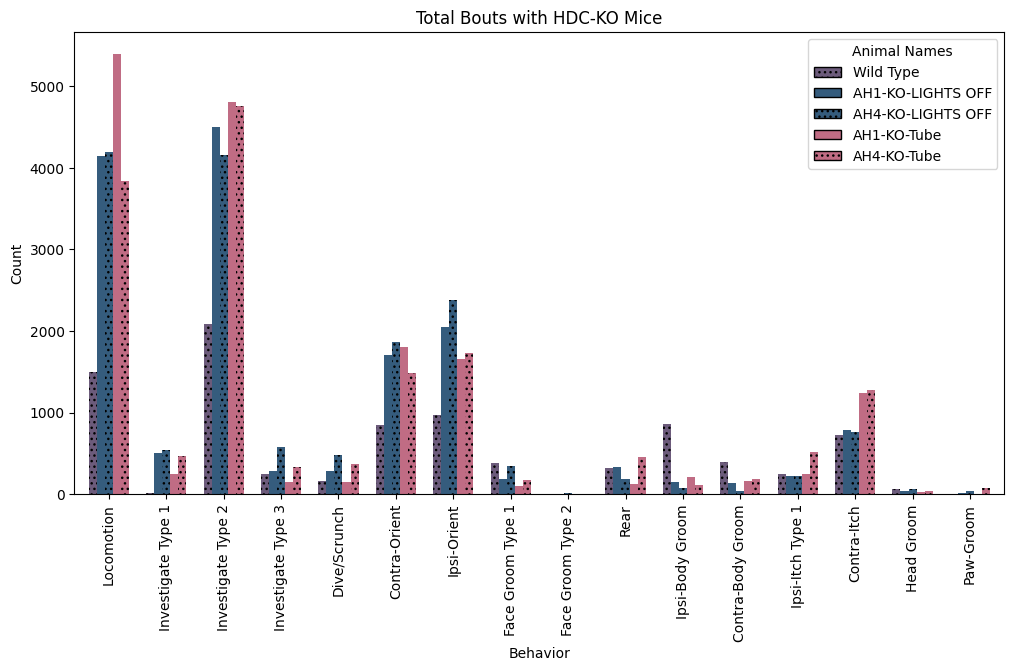

In [2]:
animal_name_order=[]
# Define the function to parse the CSV file
def parse_csv(filename):
    data = {}
    animal_name = ""
    
    with open(filename, newline='') as csvfile:
        first_line = csvfile.readline()
        animal_name = first_line.strip() 
        # Remove the comma
        cleaned_animal_name = animal_name.replace(',', '')
        animal_name_order.append(cleaned_animal_name)
    
    reader = pd.read_csv(filename, skiprows=1)
    for index, row in reader.iterrows():
        if animal_name:
            key = row.iloc[0]
            value = float(row.iloc[1])
            data[animal_name] = data.get(animal_name, {})
            data[animal_name][key] = value
    return data

root = tk.Tk()
root.withdraw()

file_paths = filedialog.askopenfilenames(
    title="Select CSV Files",
    filetypes=[("CSV Files", "*.csv")]
)

def custom_sort(animal_name):
    # Define a regular expression pattern to extract numeric values
    numeric_pattern = r'(\d+)'

    # Function to extract numeric values from an animal name
    def extract_numeric_value(name):
        match = re.search(numeric_pattern, name)
        if match:
            return int(match.group(1))
        return None

    # Function to extract the base name without numeric values
    def extract_base_name(name):
        return re.sub(numeric_pattern, '', name)

    # Define sorting priorities based on animal name types
    priorities = {
        'Wild Type': 0,
        'AH-KO-LIGHTS OFF': 1,
        'AH-KO-Tube': 2,
        # Add more types as needed with appropriate priorities
    }

    # Extract numeric value and base name from the animal name
    numeric_value = extract_numeric_value(animal_name)
    base_name = extract_base_name(animal_name)

    # Determine the priority based on the base name
    priority = priorities.get(base_name, len(priorities))

    # If there is a numeric value, adjust the priority based on it
    if numeric_value is not None:
        priority += numeric_value / 1000  # Divide by 1000 for finer sorting 
    
    return priority

if not file_paths:
    print("No CSV files selected.")
else:
    keys = []
    values = []
    colors = []
    animal_priorities = {}
    
    for file_path in file_paths:
        file_data = parse_csv(file_path)
        for animal, data in file_data.items():
            if 'insignificant' in data:
                del data['insignificant']  # Remove the 'Insignificant' key and its data

            # Strip the comma from the animal name and add it to the dictionary with its priority
            animal_name_stripped = animal.strip(',')
            animal_priorities[animal_name_stripped] = custom_sort(animal_name_stripped)

            for key, value in data.items():
                keys.append(key)
                values.append(value)
                colors.append(animal_name_stripped)  # Use the stripped name for colors
                
    parts = file_paths[0].split('/')
    #print(parts)
    directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
    print(directory_path)
    df = pd.DataFrame({'Keys': keys, 'Values': values, 'Animal': colors})

    # Filter out the 'Insignificant' key and its data from the DataFrame
    df = df[df['Keys'] != 'insignificant']
    # Reorder the DataFrame by the desired animal order and index order
    
    # Sort the animal_name_order list using the custom_sort function
    animal_name_order = sorted(animal_name_order, key=custom_sort)
    # Print the sorted animal order
    animal_order = animal_name_order
    key_order = ['Locomotion', 'Investigate Type 1','Investigate Type 2', 'Investigate Type 3',
                 'Dive/Scrunch', 'Contra-Orient','Ipsi-Orient','Face Groom Type 1',
                 'Face Groom Type 2', 'Rear','Ipsi-Body Groom','Contra-Body Groom', 'Ipsi-Itch Type 1',
                 'Contra-Itch', 'Head Groom', 'Paw-Groom'
                ] # Get the unique keys in the order they appear in the DataFrame
    
    pivot_df = df.pivot(index='Keys', columns='Animal', values='Values')
    pivot_df.columns= pivot_df.columns.str.strip(',').str.strip()
    # Reorder columns based on animal_order
    pivot_df = pivot_df[animal_order]

    # Reorder rows based on key_order
    pivot_df = pivot_df.reindex(key_order)
    
    # Create a legend with labels and custom colors based on priorities
    legend_handles = []
    colors = []
   
    for animal in animal_order:
        priority = animal_priorities.get(animal, 0)  # Get the priority from the dictionary

        if priority == 0:
            color = '#6C5B7B'
        elif 1 <= priority < 2:
            color = '#355C7D'
        elif 2 <= priority < 3:
            color = '#C06C84'
        else:
            color = 'yellow'  # Default to gray for unknown priorities

        colors.append(color)

    ax = pivot_df.plot(kind='bar', figsize=(12, 6), color=colors, width=0.7)

    
    folders = (os.path.dirname(file_path)).split('/')
    fol5 = folders[5].split(' ')  # Split element at position 3 by hyphen
    fol6 = folders[6]  
    
    # You want to count skip every 16 which is one animal because hatching identifies the animal. 
    # This ensures there is one animal per group with hatching 
    step = 16  # Step size: The number of behaviors for each animal
    counter = 0  # Counter to keep track of the current position
    bars_to_hatch = []
    while counter < len(ax.patches):
        bars_to_hatch.extend(ax.patches[counter:counter+step])
        counter += step * 2

    for i, bar in enumerate(bars_to_hatch):
        if i < 16:
            bar.set_hatch('...')  # Apply '***' hatch pattern to the first 16 bars
        else:
            bar.set_hatch('...')  # Apply '///' hatch pattern to the next 16 bars
    

    plt.title(f'Total Bouts with HDC-KO Mice')
    plt.xlabel('Behavior')
    plt.ylabel('Count')
    # Print the table
    print(pivot_df)

    # Create a legend with labels and hatching patterns
    legend_handles = []
    
    for i, animal in enumerate(animal_order):
        # Determine the hatch pattern based on the index
        hatch = '...' if i % 2 == 0 else ''
            
        # Create a colored patch with a label and custom hatch pattern
        color_patch = mpatches.Patch(facecolor=colors[i], edgecolor='black', label=animal, hatch=hatch)

        # Append the color patch to the legend_handles list
        legend_handles.append(color_patch)

    # Add a legend to the plot, specifying the custom legend handles
    plt.legend(handles=legend_handles, title='Animal Names')

    # Set the file path where you want to save the plot
    save_path = os.path.join(directory_path, 'Combined Total Bouts Plot.png')  # You can specify the file format (e.g., 'plot.png')

    # Save the plot to the specified file path
    plt.gcf().savefig(save_path, dpi=300)

    # Display the plot (optional)
    plt.show()
    plt.close()

In [51]:
print(pivot_df.columns)

print("Animal Order:", animal_order)
print(animal_priorities)



Index(['Wild Type', 'AH1-KO-LIGHTS OFF', 'AH4-KO-LIGHTS OFF', 'AH1-KO-Tube',
       'AH4-KO-Tube'],
      dtype='object', name='Animal')
Animal Order: ['Wild Type', 'AH1-KO-LIGHTS OFF', 'AH4-KO-LIGHTS OFF', 'AH1-KO-Tube', 'AH4-KO-Tube']
{'Wild Type,': 3, 'AH1-KO-Tube,': 3.001, 'AH1-KO-LIGHTS OFF,': 3.001, 'AH4-KO-LIGHTS OFF': 1.004, 'AH4-KO-Tube': 2.004}


In [54]:
import scipy.stats as stats

# Define the significance level
alpha = 0.05

# Create a dictionary to store t-test results for each behavior
t_test_results = {}

# Loop through the behaviors in key_order
for behavior in key_order:
    # Select the data for each animal for the current behavior
    behavior_data = {animal: df[(df['Animal'] == animal) & (df['Keys'] == behavior)]['Values'] for animal in animal_order}
    
    # Remove rows with NaN values
    behavior_data_cleaned = {animal: data.dropna() for animal, data in behavior_data.items()}
    
    # Perform t-tests for all pairs of animals for the current behavior
    t_test_results[behavior] = {}
    for i in range(len(animal_order)):
        for j in range(i+1, len(animal_order)):
            animal1 = animal_order[i]
            animal2 = animal_order[j]
            
            # Perform the t-test on cleaned data
            t_statistic, p_value = stats.ttest_ind(behavior_data_cleaned[animal1], behavior_data_cleaned[animal2])
            
            # Store the results in the dictionary
            t_test_results[behavior][(animal1, animal2)] = {
                'T-Statistic': t_statistic,
                'P-Value': p_value,
                'Significant': p_value < alpha
            }

# Print the t-test results
for behavior, results in t_test_results.items():
    print(f'Behavior: {behavior}')
    for animals, data in results.items():
        animal1, animal2 = animals
        print(f'{animal1} vs. {animal2}:')
        print(f'T-Statistic: {data["T-Statistic"]}')
        print(f'P-Value: {data["P-Value"]}')
        if data['Significant']:
            print('The difference is statistically significant (reject the null hypothesis)')
        else:
            print('The difference is not statistically significant (fail to reject the null hypothesis)')
    print()


Behavior: Locomotion
Wild Type vs. AH1-KO-LIGHTS OFF:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
Wild Type vs. AH4-KO-LIGHTS OFF:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
Wild Type vs. AH1-KO-Tube:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
Wild Type vs. AH4-KO-Tube:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
AH1-KO-LIGHTS OFF vs. AH4-KO-LIGHTS OFF:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
AH1-KO-LIGHTS OFF vs. AH1-KO-Tube:
T-Statistic: nan
P-Value: nan
The difference is not statistically significant (fail to reject the null hypothesis)
AH1-KO-LIGHTS OFF vs. AH4-KO-Tube:
T-Statistic: nan
P-Value: nan
The difference is not statis

/Users/kaycei/anaconda3/envs/closed-loop/lib/python3.10/site-packages/scipy/stats/_stats_py.py:6988: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH4-KO/WT vs AH4 vs AH4-Tube/Duration
Animal              Wild Type  AH1-KO-LIGHTS OFF  AH4-KO-LIGHTS OFF  \
Keys                                                                  
Locomotion              0.234              0.325              0.312   
Investigate Type 1      0.142              0.241              0.244   
Investigate Type 2      0.497              0.278              0.284   
Investigate Type 3      0.255              0.210              0.192   
Dive/Scrunch            0.118              0.123              0.120   
Contra-Orient           0.119              0.127              0.123   
Ipsi-Orient             0.136              0.137              0.132   
Face Groom Type 1       0.189              0.187              0.190   
Face Groom Type 2         NaN              0.133              0.238   
Rear                    0.230              0.180              0.151   
Ipsi-Body Groom         0.265              0.136             

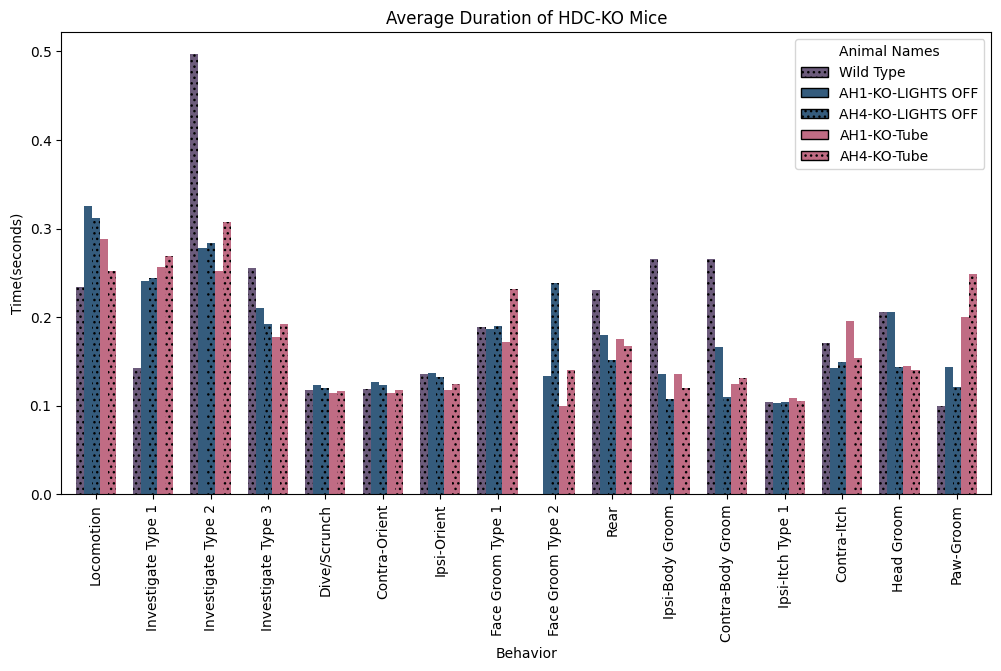

In [2]:
animal_name_order=[]
# Define the function to parse the CSV file
def parse_csv(filename):
    data = {}
    animal_name = ""
    
    with open(filename, newline='') as csvfile:
        first_line = csvfile.readline()
        animal_name = first_line.strip() 
        # Remove the comma
        cleaned_animal_name = animal_name.replace(',', '')
        animal_name_order.append(cleaned_animal_name)
    
    reader = pd.read_csv(filename, skiprows=1)
    for index, row in reader.iterrows():
        if animal_name:
            key = row.iloc[0]
            value = float(row.iloc[1])
            data[animal_name] = data.get(animal_name, {})
            data[animal_name][key] = value
    return data

root = tk.Tk()
root.withdraw()

file_paths = filedialog.askopenfilenames(
    title="Select CSV Files",
    filetypes=[("CSV Files", "*.csv")]
)

def custom_sort(animal_name):
    # Define a regular expression pattern to extract numeric values
    numeric_pattern = r'(\d+)'

    # Function to extract numeric values from an animal name
    def extract_numeric_value(name):
        match = re.search(numeric_pattern, name)
        if match:
            return int(match.group(1))
        return None

    # Function to extract the base name without numeric values
    def extract_base_name(name):
        return re.sub(numeric_pattern, '', name)

    # Define sorting priorities based on animal name types
    priorities = {
        'Wild Type': 0,
        'AH-KO-LIGHTS OFF': 1,
        'AH-KO-Tube': 2,
        # Add more types as needed with appropriate priorities
    }

    # Extract numeric value and base name from the animal name
    numeric_value = extract_numeric_value(animal_name)
    base_name = extract_base_name(animal_name)

    # Determine the priority based on the base name
    priority = priorities.get(base_name, len(priorities))

    # If there is a numeric value, adjust the priority based on it
    if numeric_value is not None:
        priority += numeric_value / 1000  # Divide by 1000 for finer sorting 
    
    return priority

if not file_paths:
    print("No CSV files selected.")
else:
    keys = []
    values = []
    colors = []
    animal_priorities = {}
    
    for file_path in file_paths:
        file_data = parse_csv(file_path)
        for animal, data in file_data.items():
            if 'insignificant' in data:
                del data['insignificant']  # Remove the 'Insignificant' key and its data

            # Strip the comma from the animal name and add it to the dictionary with its priority
            animal_name_stripped = animal.strip(',')
            animal_priorities[animal_name_stripped] = custom_sort(animal_name_stripped)

            for key, value in data.items():
                keys.append(key)
                values.append(value)
                colors.append(animal_name_stripped)  # Use the stripped name for colors
                
    parts = file_paths[0].split('/')
    #print(parts)
    directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
    print(directory_path)
    df = pd.DataFrame({'Keys': keys, 'Values': values, 'Animal': colors})

    # Filter out the 'Insignificant' key and its data from the DataFrame
    df = df[df['Keys'] != 'insignificant']
    # Reorder the DataFrame by the desired animal order and index order
    
    # Sort the animal_name_order list using the custom_sort function
    animal_name_order = sorted(animal_name_order, key=custom_sort)
    # Print the sorted animal order
    animal_order = animal_name_order
    key_order = ['Locomotion', 'Investigate Type 1','Investigate Type 2', 'Investigate Type 3',
                 'Dive/Scrunch', 'Contra-Orient','Ipsi-Orient','Face Groom Type 1',
                 'Face Groom Type 2', 'Rear','Ipsi-Body Groom','Contra-Body Groom', 'Ipsi-Itch Type 1',
                 'Contra-Itch', 'Head Groom', 'Paw-Groom'
                ] # Get the unique keys in the order they appear in the DataFrame
    
    pivot_df = df.pivot(index='Keys', columns='Animal', values='Values')
    pivot_df.columns= pivot_df.columns.str.strip(',').str.strip()
    # Reorder columns based on animal_order
    pivot_df = pivot_df[animal_order]

    # Reorder rows based on key_order
    pivot_df = pivot_df.reindex(key_order)
    
    # Create a legend with labels and custom colors based on priorities
    legend_handles = []
    colors = []
   
    for animal in animal_order:
        priority = animal_priorities.get(animal, 0)  # Get the priority from the dictionary

        if priority == 0:
            color = '#6C5B7B'
        elif 1 <= priority < 2:
            color = '#355C7D'
        elif 2 <= priority < 3:
            color = '#C06C84'
        else:
            color = 'yellow'  # Default to gray for unknown priorities

        colors.append(color)

    ax = pivot_df.plot(kind='bar', figsize=(12, 6), color=colors, width=0.7)

    
    folders = (os.path.dirname(file_path)).split('/')
    fol5 = folders[5].split(' ')  # Split element at position 3 by hyphen
    fol6 = folders[6]  
    
    # You want to count skip every 16 which is one animal because hatching identifies the animal. 
    # This ensures there is one animal per group with hatching 
    step = 16  # Step size: The number of behaviors for each animal
    counter = 0  # Counter to keep track of the current position
    bars_to_hatch = []
    while counter < len(ax.patches):
        bars_to_hatch.extend(ax.patches[counter:counter+step])
        counter += step * 2

    for i, bar in enumerate(bars_to_hatch):
        if i < 16:
            bar.set_hatch('...')  # Apply '***' hatch pattern to the first 16 bars
        else:
            bar.set_hatch('...')  # Apply '///' hatch pattern to the next 16 bars

    plt.title(f'Average Duration of HDC-KO Mice')
    plt.xlabel('Behavior')
    plt.ylabel('Time(seconds)')
    # Print the table
    print(pivot_df)

    # Create a legend with labels and hatching patterns
    legend_handles = []
    
    for i, animal in enumerate(animal_order):
        # Determine the hatch pattern based on the index
        hatch = '...' if i % 2 == 0 else ''
            
        # Create a colored patch with a label and custom hatch pattern
        color_patch = mpatches.Patch(facecolor=colors[i], edgecolor='black', label=animal, hatch=hatch)

        # Append the color patch to the legend_handles list
        legend_handles.append(color_patch)

    # Add a legend to the plot, specifying the custom legend handles
    plt.legend(handles=legend_handles, title='Animal Names')

    # Set the file path where you want to save the plot
    save_path = os.path.join(directory_path, 'Combined Average Duration Plot.png')  # You can specify the file format (e.g., 'plot.png')

    # Save the plot to the specified file path
    plt.gcf().savefig(save_path, dpi=300)

    # Display the plot (optional)
    plt.show()
    plt.close()

In [3]:
print(pivot_df.columns)


Index(['Wild Type', 'AH1-KO-LIGHTS OFF', 'AH4-KO-LIGHTS OFF', 'AH1-KO-Tube',
       'AH4-KO-Tube'],
      dtype='object', name='Animal')


In [4]:
print(file_paths[0])
parts = file_paths[0].split('/')
print(parts)
directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
print(directory_path)

/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH4-KO/WT vs AH4 vs AH4-Tube/Duration/AD6-D2-Duration data.csv
['', 'Users', 'kaycei', 'K on Server (NoMachine)', 'KayCei', 'HDC', 'AH4-KO', 'WT vs AH4 vs AH4-Tube', 'Duration', 'AD6-D2-Duration data.csv']
/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH4-KO/WT vs AH4 vs AH4-Tube/Duration
